In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format
from pandas.plotting import autocorrelation_plot
from math import sqrt
import researchpy as rp
import scipy as sp
from scipy import stats
import scipy.signal
from scipy.signal import fftconvolve, convolve
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import random as ran
from pprint import pprint

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn import datasets
from sklearn import set_config
set_config(display='diagram')
from xgboost import XGBClassifier, XGBRegressor
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
#from textacy.preprocess import preprocess_text

from gensim import corpora, models, matutils
from collections import defaultdict, Counter

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf

import patsy
from itertools import combinations

import graphviz
import json
import requests
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from time import sleep
import re
import twitter

In [2]:
%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Build and document a working model, prototype, recommendation, or solution

Note: The new Statcast metrics are available beginning from the 2015 baseball season to the current season. I downloaded the 2015-2017 baseball season data for all teams which will be used in the data modeling.

## [pybaseball](https://github.com/jldbc/pybaseball) 
Pull current and historical baseball statistics using Python (Statcast, Baseball Reference, FanGraphs)

`pybaseball` is a Python package for baseball data analysis. This package scrapes Baseball Reference, Baseball Savant, and FanGraphs so you don't have to. The package retrieves statcast data, pitching stats, batting stats, division standings/team records, awards data, and more. Data is available at the individual pitch level, as well as aggregated at the season level and over custom time periods. See the [docs](https://github.com/jldbc/pybaseball/tree/master/docs) for a comprehensive list of data acquisition functions.

**Statcast**

The statcast function retrieves pitch-level statcast data for a given date or range or dates.

statcast(start_dt=[yesterday's date], end_dt=None, team=None)

In [3]:
# Pull advanced metrics from Major League Baseball's Statcast system
#from pybaseball import statcast

# Look up a player's MLBAM, Retrosheet, FanGraphs, and Baseball Reference ID by name
#from pybaseball import playerid_lookup

### Reading a File

In [4]:
# Create data path variable for loading data
data_path = '/Users/yangweichle/Documents/Employment/TRAINING/DATA SCIENCE/PROJECTS/PredictingBaseballStatistics/Datasets/'

In [5]:
# Read file into DataFrame
# Note: header=0 disables the header from the file
all_MLB_teams2015_2017 = pd.read_csv(data_path + 'all_MLB_teams2015_2017.csv', header=0) # Comma-separated values file

### Examine the DataFrame

In [6]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017.shape[0], all_MLB_teams2015_2017.shape[1]))

Rows: 2139920, Cols: 91


In [7]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist
#       show_counts: whether to show the non-null counts
all_MLB_teams2015_2017.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139920 entries, 0 to 2139919
Data columns (total 91 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   Unnamed: 0                       2139920 non-null  int64  
 1   index                            2139920 non-null  int64  
 2   pitch_type                       2136106 non-null  object 
 3   game_date                        2139920 non-null  object 
 4   release_speed                    2137415 non-null  float64
 5   release_pos_x                    2118565 non-null  float64
 6   release_pos_z                    2118565 non-null  float64
 7   player_name                      2139920 non-null  object 
 8   batter                           2139920 non-null  float64
 9   pitcher                          2139920 non-null  float64
 10  events                           553868 non-null   object 
 11  description                      2139920 non-null 

In [8]:
# Column names (which is "an index")
all_MLB_teams2015_2017.columns

Index(['Unnamed: 0', 'index', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'pos2_person_id', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pos1_person_id',
       'pos2_person_id.1', 'pos3_person_id', 'pos4_person_id',
       'pos5_person_id', 'pos6_person_id', 'pos7_person

In [9]:
# Sort a DataFrame by multiple columns
# Note: ascending: sort ascending vs. descending; ascending=True is default
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True)

In [10]:
# Print the first 5 rows and the last 5 rows of the DataFrame
all_MLB_teams2015_2017.head().append(all_MLB_teams2015_2017.tail())

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
2139919,702491,17584,FF,2015-04-05,93.6,2.552,5.5293,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139918,702490,17583,FF,2015-04-05,93.4,2.5694,5.6476,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139917,702489,17582,FF,2015-04-05,94.8,2.6266,5.2936,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139916,702488,17581,FF,2015-04-05,91.6,NaN,NaN,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139915,702487,17580,CU,2015-04-05,75.9,NaN,NaN,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,4,650,FT,2017-10-01,95.9,-0.8903,6.1341,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
3,3,636,CH,2017-10-01,82.8,-0.9901,6.0626,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
2,2,620,FF,2017-10-01,94.7,-0.6208,6.3387,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
1,1,615,FC,2017-10-01,91.8,-1.0777,6.1772,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
0,0,597,FC,2017-10-01,91.9,-1.1948,5.9921,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN


#### Identifying important columns to include in the DataFrame.

In [11]:
# Select multiple columns
# Note: release_speed = Pitch Velocity (MPH)
#       bb_type = Batted Ball Type
#       launch_speed = Exit Velocity (MPH)
#       launch_angle = Launch Angle (Degrees)
baseball_cols = ['game_date', 'home_team', 'away_team', 'player_name', 'pitcher', 'pitch_type', 'pitch_name', 'release_speed',
                 'batter', 'events', 'description', 'bb_type', 'des', 'launch_speed', 'launch_angle', 'hit_distance_sc'] 
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017[baseball_cols]

In [12]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 2139920, Cols: 16


In [13]:
# Print the first 5 rows of the DataFrame
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,release_speed,batter,events,description,bb_type,des,launch_speed,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.6,"572,761.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.4,"572,761.0",NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,94.8,"572,761.0",NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,91.6,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,75.9,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN


In [14]:
# Rename one or more columns in the original DataFrame rather than returning a new view
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.rename(columns={'release_speed': 'pitch_velocity',
                                                                        'bb_type': 'batted_ball_type',
                                                                        'launch_speed': 'exit_velocity'})

In [15]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist
#       show_counts: whether to show the non-null counts
all_MLB_teams2015_2017_new.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139920 entries, 2139919 to 0
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   game_date         2139920 non-null  object 
 1   home_team         2139920 non-null  object 
 2   away_team         2139920 non-null  object 
 3   player_name       2139920 non-null  object 
 4   pitcher           2139920 non-null  float64
 5   pitch_type        2136106 non-null  object 
 6   pitch_name        2136106 non-null  object 
 7   pitch_velocity    2137415 non-null  float64
 8   batter            2139920 non-null  float64
 9   events            553868 non-null   object 
 10  description       2139920 non-null  object 
 11  batted_ball_type  386941 non-null   object 
 12  des               553866 non-null   object 
 13  exit_velocity     554876 non-null   float64
 14  launch_angle      554901 non-null   float64
 15  hit_distance_sc   508478 non-null   float64
dtype

### Examine Missing Values

In [16]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
pitch_type,3814,0.18
pitch_name,3814,0.18
pitch_velocity,2505,0.12
events,1586052,74.12
batted_ball_type,1752979,81.92
des,1586054,74.12
exit_velocity,1585044,74.07
launch_angle,1585019,74.07
hit_distance_sc,1631442,76.24


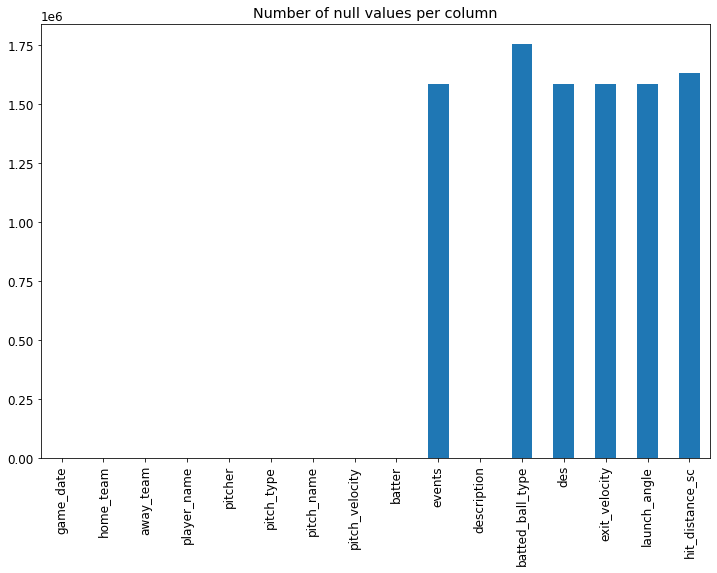

In [17]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar();
plt.title('Number of null values per column');

#### Approach for excluding records:

Each record represents an interaction between a pitcher and a batter (i.e., a pitch thrown by the pitcher to the batter).  The goal is to keep any interaction for which Statcast could provide valid measurements for the metrics `launch_speed`, `launch_angle`, and `hit_distance_sc`.

In order to do so, non-batted ball records will be excluded. <br>

- Drop all `events` = NaN which represent interactions where the batter did not make contact with the ball or the batter made contact with the ball but it was hit foul (e.g., ball, foul, called strike, swinging strike, blocked ball, foul tip, intentional ball, foul bunt, swinging strike blocked, missed bunt, pitchout)

- Drop all `batted_ball_type` = NaN which represents other remaining events where there was not a batted ball (e.g., strikeout, walk, hit by pitch, intentional walk, caught stealing, etc.)

#### Examine `events` column for missingness.

In [18]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
def value_counts_func(df, var, bar, title=''):
    value_counts = df[var].value_counts(dropna=False)
    value_percents = round(df[var].value_counts(normalize=True, dropna=False)*100, 2)
    df_ = pd.DataFrame({'counts': value_counts, 'percentage': value_percents}).rename_axis(var).reset_index()
    
    if bar:
        # Create a vertical bar plot
        # Note: figsize: a tuple (width, height) in inches
        #       rot: rotation for ticks (xticks for vertical, yticks for horizontal plots)
        percents = df[var].value_counts(normalize=True, dropna=False)*100
        ax = percents.plot(kind='bar', figsize=(10, 6), rot=0);
        ax.set_title(title);
        ax.set_ylabel('Percentage');

    format_dict = {'percentage': '{:.2f}'}
    return df_.style.format(format_dict).hide_index()

In [19]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'events', bar=False)

events,counts,percentage
nan,1586052,74.12
field_out,223381,10.44
strikeout,116120,5.43
single,82491,3.85
walk,42138,1.97
double,24898,1.16
home_run,16629,0.78
force_out,11500,0.54
grounded_into_double_play,11266,0.53
hit_by_pitch,5019,0.23


In [20]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.events.isna() # alias of isnull()
null_events = all_MLB_teams2015_2017_new.events.isnull()
all_MLB_teams2015_2017_new[null_events]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.6,"572,761.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.4,"572,761.0",NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,94.8,"572,761.0",NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,91.6,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,75.9,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FF,4-Seam Fastball,96.0,"595,885.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
4,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FT,2-Seam Fastball,95.9,"595,885.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
3,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",CH,Changeup,82.8,"595,885.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FF,4-Seam Fastball,94.7,"595,885.0",NaN,ball,NaN,NaN,75.0,-7.6433,20.0


#### What types of interactions occurred for missing `events`?

In [21]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new[null_events], 'description', bar=False)

description,counts,percentage
ball,676751,42.67
foul,371731,23.44
called_strike,333190,21.01
swinging_strike,131229,8.27
blocked_ball,45367,2.86
foul_tip,10704,0.67
foul_bunt,6228,0.39
intent_ball,4724,0.30
swinging_strike_blocked,4312,0.27
missed_bunt,1299,0.08


#### Drop missing values from `events` column.

In [22]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['events'], inplace=True)

#### Examine `batted_ball_type` column for missingness.

batted_ball_type,counts,percentage
ground_ball,178646,32.25
nan,166927,30.14
line_drive,99714,18.00
fly_ball,81752,14.76
popup,26829,4.84


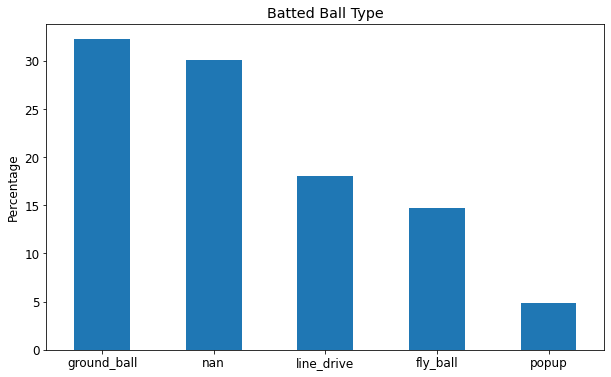

In [23]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'batted_ball_type', bar=True, title='Batted Ball Type')

In [24]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.batted_ball_type.isna() # alias of isnull()
null_batted_ball_type = all_MLB_teams2015_2017_new.batted_ball_type.isnull()
all_MLB_teams2015_2017_new[null_batted_ball_type]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139906,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,76.8,"425,509.0",strikeout,swinging_strike,NaN,Jhonny Peralta strikes out swinging.,NaN,NaN,NaN
2139901,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FC,Cutter,89.9,"571,431.0",strikeout,swinging_strike,NaN,Matt Adams strikes out swinging.,NaN,NaN,NaN
2139890,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,84.9,"519,203.0",strikeout,called_strike,NaN,Anthony Rizzo called out on strikes.,NaN,NaN,NaN
2139882,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,92.0,"425,877.0",strikeout,swinging_strike,NaN,Yadier Molina strikes out swinging.,NaN,NaN,NaN
2139875,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,89.6,"543,939.0",walk,ball,NaN,Kolten Wong walks.,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,2017-10-01,NYY,TOR,Domingo German,"593,334.0",FF,4-Seam Fastball,97.0,"606,192.0",strikeout,swinging_strike,NaN,Teoscar Hernandez strikes out swinging.,NaN,NaN,NaN
44,2017-10-01,NYY,TOR,Ryan Tepera,"572,193.0",FC,Cutter,88.9,"592,122.0",strikeout,swinging_strike,NaN,Tyler Austin strikes out swinging.,NaN,NaN,NaN
38,2017-10-01,NYY,TOR,Ryan Tepera,"572,193.0",FC,Cutter,89.5,"543,305.0",strikeout,swinging_strike,NaN,Aaron Hicks strikes out swinging.,NaN,NaN,NaN
29,2017-10-01,NYY,TOR,Ben Heller,"621,294.0",CU,Curveball,82.8,"620,446.0",strikeout,swinging_strike,NaN,Richard Urena strikes out swinging.,NaN,NaN,NaN


#### What types of `events` occurred for missing `batted_ball_type`?

In [25]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new[null_batted_ball_type], 'events', bar=False)

events,counts,percentage
strikeout,116120,69.56
walk,42138,25.24
hit_by_pitch,5019,3.01
intent_walk,1884,1.13
caught_stealing_2b,696,0.42
strikeout_double_play,435,0.26
pickoff_caught_stealing_2b,131,0.08
other_out,120,0.07
catcher_interf,113,0.07
pickoff_1b,95,0.06


#### Drop missing values from `batted_ball_type` column.

In [26]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['batted_ball_type'], inplace=True)

#### Confirm whether the values for `events` and `batted_ball_type` are valid (i.e., values could provide valid measurements for Statcast metrics).

In [27]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'events', bar=False)

events,counts,percentage
field_out,223381,57.73
single,82491,21.32
double,24898,6.43
home_run,16629,4.30
force_out,11500,2.97
grounded_into_double_play,11266,2.91
field_error,4816,1.24
sac_fly,3549,0.92
sac_bunt,3149,0.81
triple,2607,0.67


batted_ball_type,counts,percentage
ground_ball,178646,46.17
line_drive,99714,25.77
fly_ball,81752,21.13
popup,26829,6.93


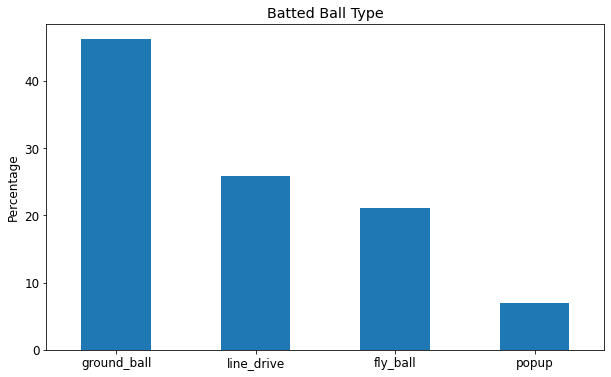

In [28]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'batted_ball_type', bar=True, title='Batted Ball Type')

In [29]:
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False).sum()

386941

In [30]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.events.fillna(' NaN'), all_MLB_teams2015_2017_new.batted_ball_type.fillna(' NaN'), margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

batted_ball_type,fly_ball,ground_ball,line_drive,popup,Total
events,,,,,
double,3502,3342,17914,140,24898
double_play,222,109,930,87,1348
field_error,159,4349,199,109,4816
field_out,60230,103445,33726,25980,223381
fielders_choice,0,301,0,0,301
fielders_choice_out,0,914,2,3,919
force_out,47,11342,74,37,11500
grounded_into_double_play,0,11266,0,0,11266
home_run,11547,0,5082,0,16629


Note: The above frequencies confirm valid values.

In [31]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
pitch_type,701,0.18
pitch_name,701,0.18
pitch_velocity,459,0.12
des,2,0.0
exit_velocity,66,0.02
launch_angle,66,0.02
hit_distance_sc,46472,12.01


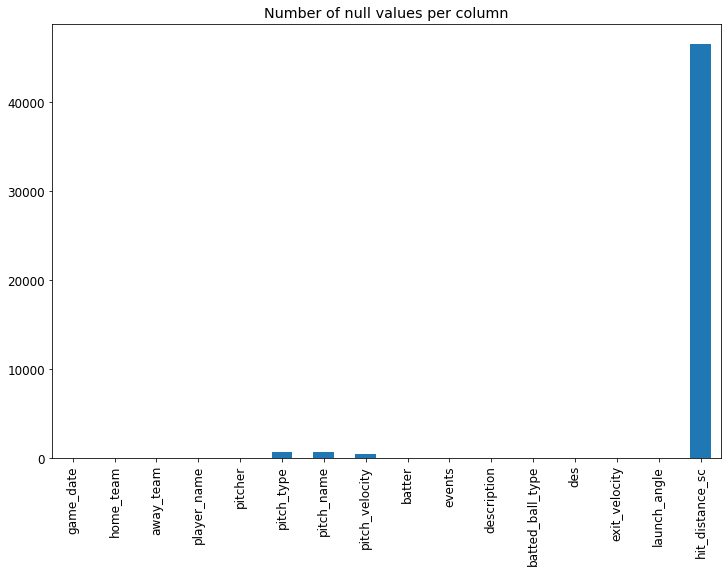

In [32]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar();
plt.title('Number of null values per column');

Note: There are still missing values for the following variables: `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle`. These variables will be used in the modeling and observations with missing values will be dropped.

#### Drop missing values from `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle` columns.

In [33]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['pitch_name', 'pitch_velocity', 'exit_velocity', 'launch_angle'], inplace=True)

### Summarize the DataFrame

In [34]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).describe()

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
count,"386,112.0","386,112.0","386,112.0","340,221.0"
mean,88.93805243038103,87.22838710008553,10.662181007583529,170.44668024607535
std,5.809725964258756,14.532314679064466,27.245970801318958,136.70036724975247
min,41.5,5.2,-88.89,0.0
25%,85.1,80.0,-8.987,22.0
50%,90.3,89.3,10.605,169.0
75%,93.3,98.1,28.520775,294.0
max,105.4,123.4,89.85,504.0


In [35]:
# Describe object columns (e.g. categorical, strings, or timestamps)
# Generates descriptive summary statistics of the count, unique values, top values, and frequency
# Note: "top" is the most common value; "freq" is the most common value's frequency
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['home_team', 'away_team', 'player_name', 'des'], axis=1).describe(include='object')

,game_date,pitch_type,pitch_name,events,description,batted_ball_type
count,386112,386112,386112,386112,386112,386112
unique,537,16,16,16,4,4
top,2015-09-30,FF,4-Seam Fastball,field_out,hit_into_play,ground_ball
freq,974,131254,131254,222928,249245,178259


In [36]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.pitch_name.fillna(' NaN'), all_MLB_teams2015_2017_new.pitch_type.fillna(' NaN'), margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

pitch_type,CH,CU,EP,FA,FC,FF,FO,FS,FT,KC,KN,PO,SC,SI,SL,UN,Total
pitch_name,,,,,,,,,,,,,,,,,
2-Seam Fastball,0,0,0,0,0,0,0,0,59444,0,0,0,0,0,0,0,59444
4-Seam Fastball,0,0,0,0,0,131254,0,0,0,0,0,0,0,0,0,0,131254
Changeup,43883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43883
Curveball,0,26046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26046
Cutter,0,0,0,0,21484,0,0,0,0,0,0,0,0,0,0,0,21484
Eephus,0,0,114,0,0,0,0,0,0,0,0,0,0,0,0,0,114
Fastball,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3
Forkball,0,0,0,0,0,0,126,0,0,0,0,0,0,0,0,0,126
Knuckle Ball,0,0,0,0,0,0,0,0,0,0,2094,0,0,0,0,0,2094


#### Drop low frequency `pitch_name` observations

In [37]:
# Return elements, either from `x` or `y`, depending on `condition`
all_MLB_teams2015_2017_new['pitch_name_low_freq'] = np.where(all_MLB_teams2015_2017_new.pitch_name.isin(['Eephus', 'Fastball', 'Forkball', 'Pitch Out', 'Screwball', 'Unknown']), 1, 0)

pitch_name_low_freq,counts,percentage
0,385848,99.93
1,264,0.07


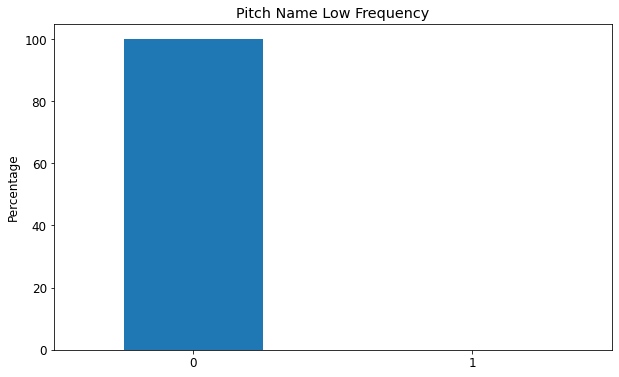

In [38]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'pitch_name_low_freq', bar=True, title='Pitch Name Low Frequency')

In [39]:
# Excluding low frequency values
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new[all_MLB_teams2015_2017_new.pitch_name_low_freq == 0]
all_MLB_teams2015_2017_new.drop('pitch_name_low_freq', axis=1, inplace=True)

In [40]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 385848, Cols: 16


In [41]:
# Calculate the correlation matrix using the default method (Pearson correlation)
baseball_correlations = all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).corr(method='pearson')
round(baseball_correlations, 3)

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
pitch_velocity,1.0,0.079,0.007,0.017
exit_velocity,0.079,1.0,0.187,0.352
launch_angle,0.007,0.187,1.0,0.733
hit_distance_sc,0.017,0.352,0.733,1.0


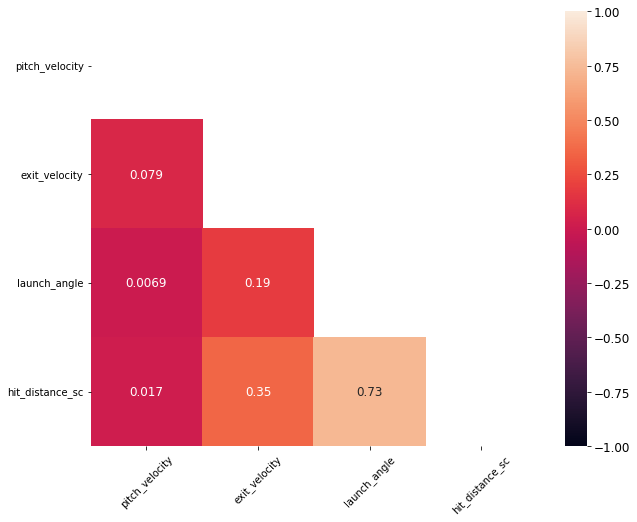

In [42]:
# Create a figure and a set of subplots
# Note: figsize: a tuple (width, height) in inches
fig, ax = plt.subplots(figsize=(10, 8));

# Return an array of zeros with the same shape and type as a given array
mask = np.zeros_like(baseball_correlations, dtype=np.bool)
# Return the indices for the upper-triangle of array
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix (color-encoded) using Seaborn's .heatmap() function
# Note: vmin, vmax: values to anchor the colormap, otherwise they are inferred from the data & other keyword arguments
#       annot: write the data value in each cell
ax = sns.heatmap(baseball_correlations, vmin=-1, vmax=1, annot=True, mask=mask, ax=ax);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, rotation=45);
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va='center', rotation=0);

plt.show();

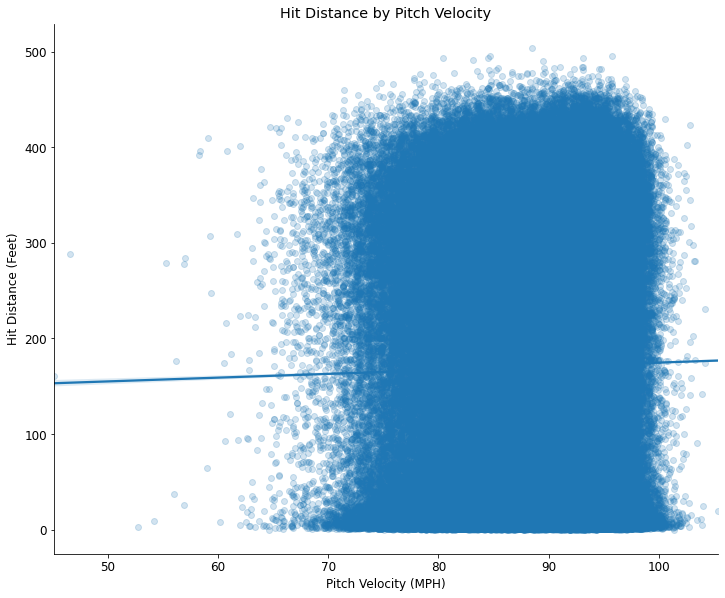

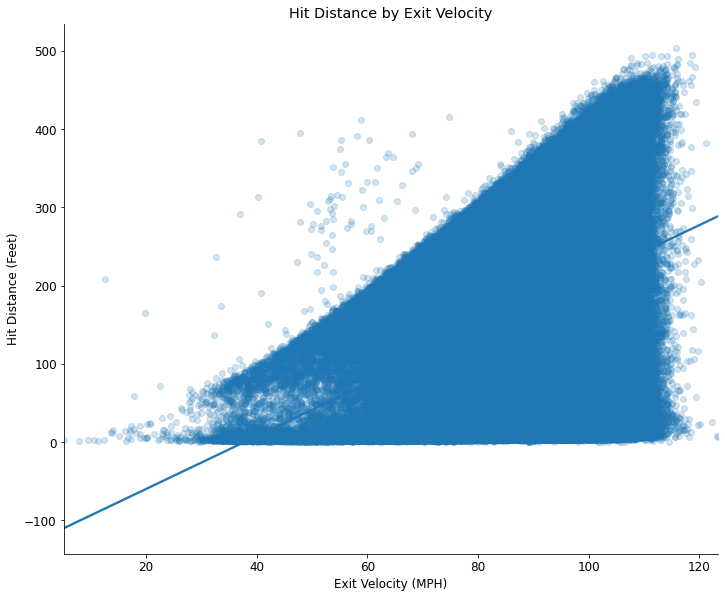

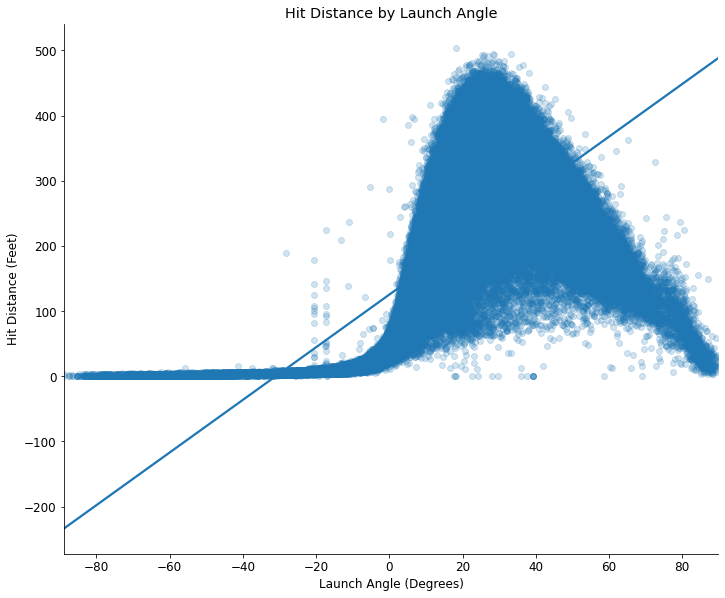

In [43]:
# Plot a simple linear relationship between two variables using Seaborn scatterplot with regression line
# Note: data: DataFrame name
#       fit_reg=True estimates and plots a regression model relating the x and y variables
#       size: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * size" gives the width of each facet in inches
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
sns.lmplot(x='pitch_velocity', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, height=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Pitch Velocity (MPH)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Pitch Velocity');
plt.show()
sns.lmplot(x='exit_velocity', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, height=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Exit Velocity');
plt.show()
sns.lmplot(x='launch_angle', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, height=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Launch Angle (Degrees)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Launch Angle');

In [44]:
# Create feature column variables
feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle']

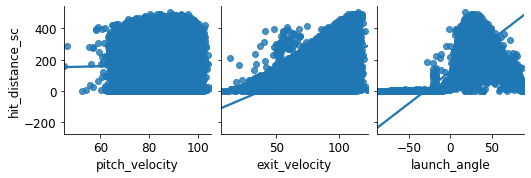

In [45]:
# Plot pairwise relationships (scatterplots for joint relationships) using Seaborn's .pairplot() function
# Note: kind: kind of plot for the non-identity relationships ('scatter' or 'reg')
sns.pairplot(all_MLB_teams2015_2017_new, x_vars=feature_cols, y_vars='hit_distance_sc', kind='reg');

In [46]:
# For each pitch name group, describe hit distance:
all_MLB_teams2015_2017_new.groupby(by='pitch_name').hit_distance_sc.describe()

,count,mean,std,min,25%,50%,75%,max
pitch_name,,,,,,,,
2-Seam Fastball,"52,265.0",153.44775662489238,137.37679837349785,0.0,14.0,125.0,281.0,493.0
4-Seam Fastball,"116,587.0",191.58778422980265,134.70236622179894,0.0,44.0,209.0,309.0,495.0
Changeup,"38,322.0",160.1829236469913,136.71519955605467,0.0,17.0,147.0,285.0,504.0
Curveball,"23,077.0",162.5189582701391,134.34749814601716,0.0,21.0,152.0,285.0,479.0
Cutter,"18,945.0",167.30329902348905,134.80569397841447,0.0,23.0,162.0,287.0,491.0
Knuckle Ball,"1,841.0",168.9228680065182,137.44151927760134,1.0,19.0,165.0,296.0,477.0
Knuckle Curve,"6,555.0",144.75194508009153,133.65453161408166,0.0,14.0,108.0,266.5,463.0
Sinker,"28,877.0",150.9022059078159,137.648595905495,0.0,13.0,118.0,279.0,478.0
Slider,"48,085.0",168.3382759696371,135.43507578845697,0.0,22.0,166.0,289.0,495.0


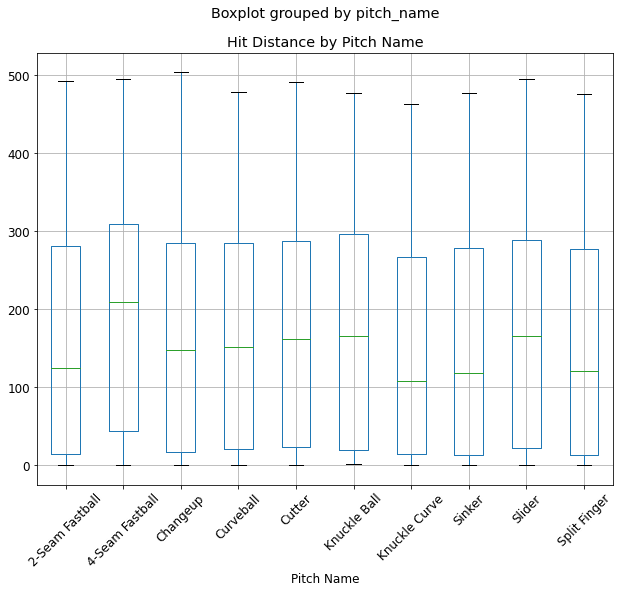

In [47]:
# Create box plots
# Note: column: used to limit data to a subset of columns
#       by: used to form box plots for separate groups
#       rot: rotation angle of labels (in degrees) with respect to the screen coordinate sytem
#       figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.boxplot(column='hit_distance_sc', by='pitch_name', rot=45, figsize=(10, 8));
plt.xlabel('Pitch Name');
plt.title('Hit Distance by Pitch Name');

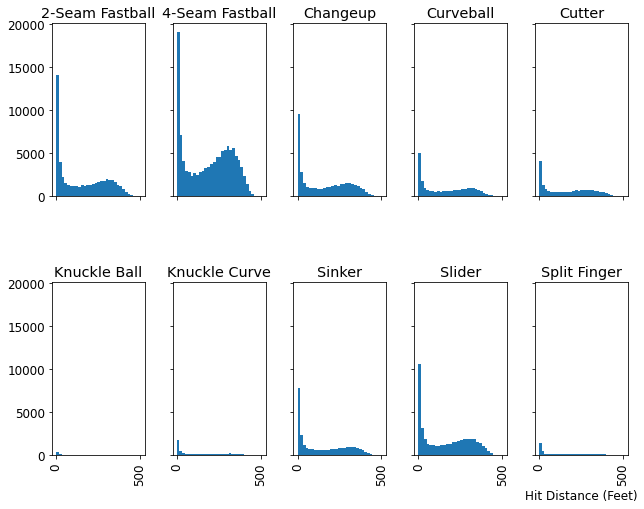

In [48]:
# Create histograms
# Note: column: used to limit data to a subset of columns
#       by: used to form histograms for separate groups
#       sharex: share x axis and set some x axis labels to invisible
#       sharey: share y axis and set some y axis labels to invisible
#       layout: tuple of (rows, columns) for the layout of the histograms
#       figsize: a tuple (width, height) in inches
#       bins: number of histogram bins to be used
all_MLB_teams2015_2017_new.hist(column='hit_distance_sc', by='pitch_name', sharex=True, sharey=True, layout=(2, 5), figsize=(10, 8), bins=30);
plt.xlabel('Hit Distance (Feet)');
plt.ylabel('Frequency');

### Data Modeling

### Using Linear Regression

#### Build and train linear regression model

Note: <br>
- `LinearRegression` does not support missing values for targets.

In [49]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
des,2,0.0
hit_distance_sc,45864,11.89


Drop missing values from `hit_distance_sc` column.

In [50]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['hit_distance_sc'], inplace=True)

Create dummy variables for `pitch_name`.

In [51]:
# Convert categorical variable into dummy/indicator variables
# Note: prefix: string to append DataFrame column names
#       drop_first=True removes the first level to get k-1 dummies out of k categorical events
# Join columns with other DataFrame either on index or on a key
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.join(pd.get_dummies(all_MLB_teams2015_2017_new.pitch_name, prefix='pitch_name', drop_first=True))
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,...,hit_distance_sc,pitch_name_4-Seam Fastball,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Knuckle Ball,pitch_name_Knuckle Curve,pitch_name_Sinker,pitch_name_Slider,pitch_name_Split Finger
2139899,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,88.1,"451,594.0",double,...,209.0,0,0,0,1,0,0,0,0,0
2139886,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,88.1,"516,770.0",field_out,...,12.0,0,0,0,1,0,0,0,0,0
2139865,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FC,Cutter,88.1,"572,761.0",single,...,189.0,0,0,0,1,0,0,0,0,0
2139861,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,87.8,"458,085.0",double,...,260.0,0,0,0,1,0,0,0,0,0
2139852,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FF,4-Seam Fastball,89.8,"424,325.0",field_out,...,364.0,1,0,0,0,0,0,0,0,0


### Building Phase

#### Predicting Hit Distance 

In [52]:
# # Create a list of features
# feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle',
#                 'pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter',
#                 'pitch_name_Knuckle Ball', 'pitch_name_Knuckle Curve', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split Finger']

In [53]:
feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle', 'pitch_name']

In [54]:
# Create X and y
X = all_MLB_teams2015_2017_new[feature_cols]
y = all_MLB_teams2015_2017_new.hit_distance_sc

In [55]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=65)

print('Length of X_train: {}'.format(len(X_train)))
print('Length of y_train: {}'.format(len(y_train)))
print('Length of X_test: {}'.format(len(X_test)))
print('Length of y_test: {}'.format(len(y_test)))

Length of X_train: 237988
Length of y_train: 237988
Length of X_test: 101996
Length of y_test: 101996


#### Compute Baseline (Null) RMSE
[How to Get Baseline Results and Why They Matter](https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/)

Note: Using a null model (i.e., using the mean value for the prediction). <br>

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [56]:
# Create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_train
y_null.fill(y_train.mean())
print(y_null)
print()

# Mean squared error (MSE) regression loss
print('Baseline (Null) MSE:', round(metrics.mean_squared_error(y_test, y_null), 3))

# Root mean squared error (RMSE) regression loss
print('Baseline (Null) RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_null)), 3))
print()

# Instantiate a regressor that makes predictions using simple rules and fit dummy regressor
# Note: stragegy: strategy to use to generate predictions
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)

# Mean squared error (MSE) regression loss
print('Baseline (Null) MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

# Root mean squared error (RMSE) regression loss
print('Baseline (Null) RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))

[170.17825269 170.17825269 170.17825269 ... 170.17825269 170.17825269
 170.17825269]

Baseline (Null) MSE: 18699.423
Baseline (Null) RMSE: 136.746

Baseline (Null) MSE: 18699.423
Baseline (Null) RMSE: 136.746


### Incorporate data preprocessing and model estimator into a pipeline
#### _Data Preprocessing_
- **Scaling Numerical Features:** Scaling numerical features (e.g., using `StandardScaler`) is a standard preprocessing step to improve the training process for machine learning models. It is performed to ensure that all numerical features have similar scales. It helps the optimization process during training and prevents features with larger scales from dominating the learning process. However, this scaling process only affects the numerical features. It does not impact the coefficients of non-numerical (categorical) features. The coefficients for categorical features are determined based on the unique categories or levels of those features and remain unchanged by the scaling of numerical features.
- **Encoding Categorical Features:** Before using categorical features in a machine learning model, you typically need to encode them into a numeric format. Common encoding techniques include one-hot encoding (for nominal features) and ordinal encoding (for ordinal features). These encoding methods create binary or integer columns to represent the categories, and these encoded features do not require scaling.
- **One-Hot Encoding:**
    - It is common practice to drop one category per feature. This is known as creating dummy variables. The reason for dropping one category (often referred to as the "reference category") is to avoid multicollinearity, which can be an issue in certain models, especially linear models like linear regression and logistic regression. Multicollinearity occurs because one-hot encoded features are linearly dependent; the value of the dropped category can be inferred from the others.
    - If you are using tree-based models (like decision trees, random forests, gradient boosting machines), it is generally not necessary to drop a category when using one-hot encoding, as these models can handle multicollinearity better than linear models. However, with large numbers of categories, one-hot encoding can lead to a very high-dimensional feature space, which might be problematic from a computational standpoint. In such cases, other encoding methods might be more efficient.
    - For distance-based algorithms like kNN and SVM, dropping one category per categorical feature after one-hot encoding is not strictly necessary. It's more important to ensure that the encoding of features are appropriate for the algorithm and that the "curse of dimensionality", where the distance in high-dimensional space becomes less meaningful, is managed effectively.

Machine learning algorithms that rely on distance-based calculations or gradient-based optimization typically require numeric features to be scaled. Scaling ensures that all features have similar scales and magnitudes, which can improve the performance and convergence of these algorithms. Here are some machine learning algorithms that commonly benefit from feature scaling:

1. **K-Nearest Neighbors (KNN):** KNN calculates distances between data points to make predictions. Feature scaling is crucial because larger magnitude features can dominate the distance calculation.

2. **Support Vector Machines (SVM):** SVM aims to find a hyperplane that maximizes the margin between classes. Scaling helps ensure that the margin is not dominated by features with larger scales.

3. **Principal Component Analysis (PCA):** PCA is used for dimensionality reduction. Feature scaling is important because PCA is sensitive to the scales of features.

4. **Gradient-Based Algorithms (e.g., Gradient Descent):** Algorithms like linear regression, logistic regression, neural networks, and many others that use gradient-based optimization techniques benefit from scaled features. Scaling helps the optimization process converge faster and more reliably.

5. **Regularized Models (e.g., Lasso, Ridge, ElasticNet):** These models involve regularization terms that depend on the scale of the coefficients. Scaling features ensures that the regularization terms treat all features equally.

6. **K-Means Clustering:** K-Means calculates cluster centroids based on the mean of data points in each cluster. Scaling helps ensure that all features contribute equally to the cluster centroids.

7. **Hierarchical Clustering:** Similar to K-Means, hierarchical clustering methods can benefit from scaled features when calculating distances between clusters.

8. **Principal Component Regression (PCR):** PCR combines PCA with regression. Scaled features are essential for both PCA and regression components.

9. **Neural Networks:** Deep learning models, including neural networks, often require feature scaling, especially when using activation functions like sigmoid or tanh.

On the other hand, some algorithms are inherently scale-invariant, meaning they don't require feature scaling. These include:

1. **Decision Trees:** Decision trees and ensemble methods based on them (e.g., Random Forests, Gradient Boosting Trees) are not sensitive to feature scales.

2. **Naive Bayes:** Naive Bayes classifiers are not affected by feature scaling since they work with probability distributions.

3. **Tree-Based Models:** Models like decision trees, Random Forests, and XGBoost are invariant to feature scaling because they make decisions based on relative feature ordering.

4. **Rule-Based Models:** Models like association rule mining (e.g., Apriori) and rule-based classifiers (e.g., RIPPER) are not affected by feature scaling.

While scaling is crucial for some algorithms, it's a best practice to perform feature scaling for most machine learning tasks. Scikit-learn provides preprocessing tools like `StandardScaler` and `MinMaxScaler` to easily scale numeric features for various algorithms.

In [57]:
# Define numerical and categorical feature columns

# List of numeric feature column names
numeric_features = ['pitch_velocity', 'exit_velocity', 'launch_angle']

# List of categorical feature column names
categorical_features = ['pitch_name']

In [58]:
# Create preprocessing transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # Scaling for numeric features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first')) # One-hot encoding for categorical features
])

# Applies transformers to columns of an array or pandas DataFrame
# -> This estimator allows different columns or column subsets of the input to be transformed separately 
#    and the features generated by each transformer will be concatenated to form a single feature space
# -> This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms 
#    or transformations into a single transformer
# Note: transformers: list of (name, transformer, column(s)) tuples specifying the transformer objects 
#                     to be applied to subsets of the data
#       remainder: {'drop', 'passthrough'} or estimator, default 'drop'
#                  By default, only the specified columns in `transformers` are transformed and combined 
#                  in the output, and the non-specified columns are dropped. (default of ``'drop'``).
#                  By specifying remainder='passthrough', all remaining columns that were not specified 
#                  in `transformers` will be automatically passed through. 
#                  This subset of columns is concatenated with the output of the transformers.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
#     remainder='passthrough'
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['pitch_velocity', 'exit_velocity',
                                  'launch_angle']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['pitch_name'])])

### Operational Phase

In [59]:
# Function to make predictions 
def prediction(X_test, regr_object, model_type_text): 
  
    # Predict using the regression model
    # Note: For a regression model, the predicted value based on X is returned
    y_pred = regr_object.predict(X_test)

    print('Results Using {}:'.format(model_type_text))
    print('Predicted values:')
    print(y_pred)
    print('')
    return y_pred

### $MSE = \frac{\sum_{i=1}^n (y_i-\hat{y})^2}{n}$

### $MAE = \frac{\sum_{i=1}^n \mid y_i-\hat{y} \mid }{n}$

In [60]:
# Function to calculate evaluation metrics
def eval_metrics(y_test, y_pred, regr_object):
    
    print('Training:')
    # Mean squared error (MSE) regression loss
    print('MSE: ', round(metrics.mean_squared_error(y_train, regr_object.predict(X_train)), 3))
    
    # Root mean squared error (RMSE) regression loss
    training_rmse = sqrt(metrics.mean_squared_error(y_train, regr_object.predict(X_train)))
    print('RMSE:', round(training_rmse, 3))
    
    # Mean absolute error (MAE) regression loss
    print('MAE: ', round(metrics.mean_absolute_error(y_train, regr_object.predict(X_train)), 3))
    
    # Coefficient of Determination R^2
    training_r2 = regr_object.score(X_train, y_train)
    print('R\u00b2:', round(training_r2, 3))
    
    # Adjusted R^2
    training_adj_r2 = 1-(1-regr_object.score(X_train, y_train)) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    print('Adjusted R\u00b2:', round(training_adj_r2, 3))
    print('')   
  
    print('Testing:')
    # Mean squared error (MSE) regression loss
    print('MSE: ', round(metrics.mean_squared_error(y_test, y_pred), 3))

    # Root mean squared error (RMSE) regression loss
    testing_rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', round(testing_rmse, 3))
    
    # Mean absolute error (MAE) regression loss
    print('MAE: ', round(metrics.mean_absolute_error(y_test, y_pred), 3))
    
    # Coefficient of Determination R^2
    testing_r2 = regr_object.score(X_test, y_test)
    print('R\u00b2:', round(testing_r2, 3))
    
    # Adjusted R^2
    testing_adj_r2 = 1-(1-regr_object.score(X_test, y_test)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Adjusted R\u00b2:', round(testing_adj_r2, 3))
    print('') 
    
    if training_rmse < testing_rmse:
        print('Testing RMSE > Training RMSE')
        print('-> Overfitting!')
    else:
        print('Testing RMSE < Training RMSE')
        print('-> Not overfitting')

### OLS Linear Regression

#### Create pipeline with the preprocessor and the `LinearRegression` 

In [61]:
# Instantiate an ordinary least squares LinearRegression model
linreg = LinearRegression()

In [62]:
# Create pipeline with the preprocessor and the regressor
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('regressor', linreg) # Regressor
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor', LinearRegression())])

In [63]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor', LinearRegression())])

#### Get the coefficient for each feature

In [64]:
## NOTE: Use the following if one-hot encoder was used as part of the 'preprocessor' step

# Categorical columns change from one-hot encoder
new_categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# Concatenate categorical columns with numerical columns (do not change) to get all columns
name = np.concatenate([numeric_features, new_categorical_features])

In [65]:
# Print the intercept and coefficient(s)
print('Intercept:', round(pipeline.named_steps['regressor'].intercept_, 4))
print('Coefficient(s):')
print(list(zip(name, np.round(pipeline.named_steps['regressor'].coef_, 4))))

Intercept: 167.9899
Coefficient(s):
[('pitch_velocity', -2.94), ('exit_velocity', 32.0664), ('launch_angle', 94.3932), ('pitch_name_4-Seam Fastball', 6.0037), ('pitch_name_Changeup', 2.3426), ('pitch_name_Curveball', -2.7181), ('pitch_name_Cutter', 1.3687), ('pitch_name_Knuckle Ball', -0.2794), ('pitch_name_Knuckle Curve', -6.9506), ('pitch_name_Sinker', -0.6188), ('pitch_name_Slider', 1.1957), ('pitch_name_Split Finger', -0.3616)]


In [66]:
coef = np.round(pipeline.named_steps['regressor'].coef_, 4)
pd.DataFrame([name, coef], index=['Name', 'Coefficient']).transpose()

,Name,Coefficient
0,pitch_velocity,-2.94
1,exit_velocity,32.0664
2,launch_angle,94.3932
3,pitch_name_4-Seam Fastball,6.0037
4,pitch_name_Changeup,2.3426
5,pitch_name_Curveball,-2.7181
6,pitch_name_Cutter,1.3687
7,pitch_name_Knuckle Ball,-0.2794
8,pitch_name_Knuckle Curve,-6.9506
9,pitch_name_Sinker,-0.6188


#### Perform Cross-Validation
- Evaluating performance using MSE and MAE as scoring metrics

In [67]:
# Evaluate metric(s) by cross-validation and also record fit/score times
# Note: scoring: strategy to evaluate the performance of the cross-validated model on the test set
#       cv: determines the cross-validation splitting strategy  (number of folds in cross-validation)
#       n_jobs: number of CPUs to use to do the computation; -1 means using all processors
#       return_train_score: whether to include train scores
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True)

In [68]:
# results = pd.DataFrame.from_dict(cv_results)
pd.DataFrame.from_dict(cv_results, orient='index').style.set_sticky(axis='index')

,0,1,2,3,4,5,6,7,8,9
fit_time,1.066511,0.977446,1.061219,0.795858,1.066916,1.015348,1.024224,0.953145,0.955145,0.866160
score_time,0.037695,0.074595,0.032726,0.056780,0.037247,0.032891,0.046114,0.036143,0.028483,0.026792
test_neg_mean_squared_error,-7708.641245,-7629.364413,-7689.376846,-7692.863474,-7687.487864,-7731.121147,-7492.631656,-7747.320836,-7596.549332,-7604.720406
train_neg_mean_squared_error,-7651.213648,-7660.012135,-7653.339029,-7652.922622,-7653.522795,-7648.658041,-7675.214166,-7646.912091,-7663.657536,-7662.789269
test_neg_mean_absolute_error,-72.796019,-72.366091,-72.557913,-72.864088,-72.590006,-72.872474,-71.969490,-73.084615,-72.391691,-72.282711
train_neg_mean_absolute_error,-72.534127,-72.609460,-72.550267,-72.545080,-72.558972,-72.543947,-72.670181,-72.498386,-72.607634,-72.604274


In [69]:
# Convert scores to positive MSE and calculate the mean
mse_scores = -cv_results['test_neg_mean_squared_error']
print('CV MSE scores for each fold:')
print(mse_scores)
print('')
print('Mean CV MSE:', round(np.mean(mse_scores), 3))
print('Mean CV RMSE:', round(np.mean(np.sqrt(mse_scores)), 3))

CV MSE scores for each fold:
[7708.64124512 7629.36441324 7689.37684613 7692.86347385 7687.48786425
 7731.12114743 7492.631656   7747.32083582 7596.54933195 7604.72040637]

Mean CV MSE: 7658.008
Mean CV RMSE: 87.509


In [70]:
# Convert scores to positive MAE and calculate the mean
mae_scores = -cv_results['test_neg_mean_absolute_error']
print('CV MAE scores for each fold:')
print(mae_scores)
print('')
print('Mean CV MAE:', round(np.mean(mae_scores), 3))

CV MAE scores for each fold:
[72.79601907 72.36609137 72.55791324 72.86408772 72.59000559 72.87247449
 71.96949049 73.08461517 72.39169078 72.28271102]

Mean CV MAE: 72.578


#### Prediction using OLS Linear Regression

In [71]:
model_type_text='OLS Linear Regression'
y_pred_linreg = prediction(X_test, pipeline, model_type_text)
eval_metrics(y_test, y_pred_linreg, pipeline)

Results Using OLS Linear Regression:
Predicted values:
[242.89292498 315.5271003  305.89855546 ...  97.22629471 132.53603745
 336.59550073]

Training:
MSE:  7656.883
RMSE: 87.504
MAE:  72.573
R²: 0.59
Adjusted R²: 0.59

Testing:
MSE:  7642.103
RMSE: 87.419
MAE:  72.504
R²: 0.591
Adjusted R²: 0.591

Testing RMSE < Training RMSE
-> Not overfitting


### Use Regularization to optimize model

- Regularization is a method for "constraining" or "regularizing" the size of the coefficients, thus "shrinking" them toward zero.
- It reduces model variance and thus minimizes overfitting.
- If the model is more complex, regularization tends to reduce variance more than it increases bias, resulting in a model that is more likely to generalize.

The goal is to locate the optimum model complexity, and thus regularization is useful when we believe our model is too complex.

#### Advice for Applying Regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between Lasso Regression and Ridge Regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicollinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of Lasso Regression and Ridge Regression.

Standardization is necessary for regularized regression because the beta values for each predictor variable must be on the same scale. If betas are different sizes just because of the scale of predictor variables, the regularization term can't determine which betas are more/less important based on their size.

### Ridge Regression

#### Find an optimal value for Ridge regression alpha using `RidgeCV`.

[RidgeCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

[How to Develop Ridge Regression Models in Python](https://machinelearningmastery.com/ridge-regression-with-python/)

*Once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Ridge performs best searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit!

In [72]:
# Define the alphas for RidgeCV
# --> Return numbers spaced evenly on a log scale
# Note: num: number of samples to generate
ridge_alphas = np.logspace(0, 5, num=200)
#ridge_alphas[0] = 10^0 = 1.0
#ridge_alphas[-1] = 10^5 = 100000.0

#### Create pipeline with the preprocessor and the `RidgeCV` 

In [73]:
# Instantiate a Ridge regression with built-in cross-validation RidgeCV mode
# Note: alphas: array of alpha values (regularization strength) to try
#       cv: number of folds in cross-validation
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=10)

In [74]:
# Create pipeline with the preprocessor and the regressor
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('regressor', ridge_cv) # Regressor
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor',
                 RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
                         cv=10))])

#### Determine the Best Alpha Value with `RidgeCV`

In [75]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Extract the best alpha value
best_alpha = pipeline.named_steps['regressor'].alpha_
print('Best alpha:', best_alpha)

Best alpha: 273.6439997074672


#### Get the coefficient for each feature
- This pipeline has been trained on the entire training dataset and has determined the best alpha value
- After training, this pipeline holds the Ridge model fitted with the best-found alpha
- Therefore, the coefficients and intercept from this model are the final, optimal parameters

In [76]:
## NOTE: Use the following if one-hot encoder was used as part of the 'preprocessor' step

# Categorical columns change from one-hot encoder
new_categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# Concatenate categorical columns with numerical columns (do not change) to get all columns
name = np.concatenate([numeric_features, new_categorical_features])

In [77]:
# Print the intercept and coefficient(s)
print('Intercept:', round(pipeline.named_steps['regressor'].intercept_, 4))
print('Coefficient(s):')
print(list(zip(name, np.round(pipeline.named_steps['regressor'].coef_, 4))))

Intercept: 167.9449
Coefficient(s):
[('pitch_velocity', -2.8786), ('exit_velocity', 32.0463), ('launch_angle', 94.2908), ('pitch_name_4-Seam Fastball', 6.0044), ('pitch_name_Changeup', 2.4044), ('pitch_name_Curveball', -2.5218), ('pitch_name_Cutter', 1.3879), ('pitch_name_Knuckle Ball', -0.0862), ('pitch_name_Knuckle Curve', -6.4527), ('pitch_name_Sinker', -0.6124), ('pitch_name_Slider', 1.272), ('pitch_name_Split Finger', -0.2742)]


In [78]:
coef = np.round(pipeline.named_steps['regressor'].coef_, 4)
pd.DataFrame([name, coef], index=['Name', 'Coefficient']).transpose()

,Name,Coefficient
0,pitch_velocity,-2.8786
1,exit_velocity,32.0463
2,launch_angle,94.2908
3,pitch_name_4-Seam Fastball,6.0044
4,pitch_name_Changeup,2.4044
5,pitch_name_Curveball,-2.5218
6,pitch_name_Cutter,1.3879
7,pitch_name_Knuckle Ball,-0.0862
8,pitch_name_Knuckle Curve,-6.4527
9,pitch_name_Sinker,-0.6124


#### Create pipeline with the preprocessor and the `Ridge` with the determined Best Alpha

In [79]:
# Instantiate a linear least squares with l2-norm regularization RidgeRegression model
# Note: alpha: regularization strength; defaults to 1.0
#       -> alpha=0 has no regularization strength, equivalent to a basic linear regression (ordinary least square)
ridge = Ridge(alpha=best_alpha)

In [80]:
# Create a new pipeline with the determined best alpha
pipeline_cv = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('regressor', ridge) # Regressor
])
pipeline_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor', Ridge(alpha=273.6439997074672))])

#### Perform Cross-Validation with the Best Alpha
- Evaluating performance using MSE and MAE as scoring metrics

In [81]:
# Evaluate metric(s) by cross-validation and also record fit/score times
# Note: scoring: strategy to evaluate the performance of the cross-validated model on the test set
#       cv: determines the cross-validation splitting strategy  (number of folds in cross-validation)
#       n_jobs: number of CPUs to use to do the computation; -1 means using all processors
#       return_train_score: whether to include train scores
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(pipeline_cv, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True)

In [82]:
# results = pd.DataFrame.from_dict(cv_results)
pd.DataFrame.from_dict(cv_results, orient='index').style.set_sticky(axis='index')

,0,1,2,3,4,5,6,7,8,9
fit_time,0.173980,0.195482,0.190491,0.195965,0.201208,0.201916,0.203980,0.201847,0.202001,0.195548
score_time,0.017176,0.019132,0.017901,0.016232,0.017569,0.020877,0.019229,0.015823,0.017255,0.017344
test_neg_mean_squared_error,-7708.227287,-7629.548309,-7688.869025,-7692.834407,-7687.288074,-7731.256571,-7492.932035,-7747.062828,-7596.846921,-7604.952944
train_neg_mean_squared_error,-7651.233837,-7660.031920,-7653.362332,-7652.942440,-7653.542774,-7648.678411,-7675.234621,-7646.931537,-7663.676305,-7662.807511
test_neg_mean_absolute_error,-72.811214,-72.384101,-72.573464,-72.881589,-72.607122,-72.890534,-71.987252,-73.101953,-72.409931,-72.300758
train_neg_mean_absolute_error,-72.551759,-72.626957,-72.567860,-72.562602,-72.576469,-72.561420,-72.687720,-72.515923,-72.625117,-72.621753


In [83]:
# Convert scores to positive MSE and calculate the mean
mse_scores = -cv_results['test_neg_mean_squared_error']
print('CV MSE scores for each fold:')
print(mse_scores)
print('')
print('Mean CV MSE:', round(np.mean(mse_scores), 3))
print('Mean CV RMSE:', round(np.mean(np.sqrt(mse_scores)), 3))

CV MSE scores for each fold:
[7708.22728699 7629.54830912 7688.8690253  7692.83440702 7687.28807408
 7731.25657124 7492.93203518 7747.06282813 7596.84692123 7604.95294439]

Mean CV MSE: 7657.982
Mean CV RMSE: 87.509


In [84]:
# Convert scores to positive MAE and calculate the mean
mae_scores = -cv_results['test_neg_mean_absolute_error']
print('CV MAE scores for each fold:')
print(mae_scores)
print('')
print('Mean CV MAE:', round(np.mean(mae_scores), 3))

CV MAE scores for each fold:
[72.81121363 72.38410055 72.57346431 72.88158905 72.6071224  72.89053429
 71.98725212 73.10195325 72.40993062 72.30075843]

Mean CV MAE: 72.595


#### Prediction using Ridge Regression with the Best Alpha
- The original pipeline has already been fitted to the training data with the best alpha
- Make predictions on the test set using the original pipeline

In [85]:
model_type_text='Ridge Regression with the Best Alpha'
y_pred_ridge = prediction(X_test, pipeline, model_type_text)
eval_metrics(y_test, y_pred_ridge, pipeline)

Results Using Ridge Regression with the Best Alpha:
Predicted values:
[242.79283899 315.38187595 305.79284662 ...  97.30835575 132.63576328
 336.43221153]

Training:
MSE:  7656.899
RMSE: 87.504
MAE:  72.588
R²: 0.59
Adjusted R²: 0.59

Testing:
MSE:  7642.139
RMSE: 87.419
MAE:  72.52
R²: 0.591
Adjusted R²: 0.591

Testing RMSE < Training RMSE
-> Not overfitting


### Lasso Regression

#### Find an optimal value for Lasso regression alpha using `LassoCV`.

[LassoCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). It is very similar to `RidgeCV`.

[How to Develop Lasso Regression Models in Python](https://machinelearningmastery.com/lasso-regression-with-python/)

*Once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Lasso, unlike Ridge, performs best searching for alpha through linear space (`np.linspace`). However, you can actually let the `LassoCV` decide itself what alphas to use by instead setting the keyword argument `n_alphas=` to however many alphas you want it to search over. It is recommended to let sklearn choose the range of alphas.

**Tip:** If you find your CV taking a long time and you're not sure if its working set `verbose=1`.

#### Create pipeline with the preprocessor and the `LassoCV` 

In [86]:
# Instantiate a Lasso linear LassoCV model with iterative fitting along a regularization path
# Note: n_alphas: number of alphas along the regularization path
#       cv: number of folds in cross-validation
#       verbose: amount of verbosity (i.e., show progress as dots)
#       n_jobs: number of CPUs to use during the cross validation; -1 means using all processors
lasso_cv = LassoCV(n_alphas=500, cv=10, n_jobs=-1)

In [87]:
# Create pipeline with the preprocessor and the regressor
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('regressor', lasso_cv) # Regressor
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor', LassoCV(cv=10, n_alphas=500, n_jobs=-1))])

#### Determine the Best Alpha Value with `LassoCV`

In [88]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Extract the best alpha value
best_alpha = pipeline.named_steps['regressor'].alpha_
print('Best alpha:', best_alpha)

Best alpha: 0.10013680041134139


#### Get the coefficient for each feature
- This pipeline has been trained on the entire training dataset and has determined the best alpha value
- After training, this pipeline holds the Lasso model fitted with the best-found alpha
- Therefore, the coefficients and intercept from this model are the final, optimal parameters

In [89]:
## NOTE: Use the following if one-hot encoder was used as part of the 'preprocessor' step

# Categorical columns change from one-hot encoder
new_categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# Concatenate categorical columns with numerical columns (do not change) to get all columns
name = np.concatenate([numeric_features, new_categorical_features])

In [90]:
# Print the intercept and coefficient(s)
print('Intercept:', round(pipeline.named_steps['regressor'].intercept_, 4))
print('Coefficient(s):')
print(list(zip(name, np.round(pipeline.named_steps['regressor'].coef_, 4))))

Intercept: 168.1189
Coefficient(s):
[('pitch_velocity', -2.1637), ('exit_velocity', 31.9322), ('launch_angle', 94.4055), ('pitch_name_4-Seam Fastball', 5.0409), ('pitch_name_Changeup', 1.9675), ('pitch_name_Curveball', -0.0), ('pitch_name_Cutter', 0.0), ('pitch_name_Knuckle Ball', 0.0), ('pitch_name_Knuckle Curve', -0.7722), ('pitch_name_Sinker', -0.0), ('pitch_name_Slider', 0.8839), ('pitch_name_Split Finger', 0.0)]


In [91]:
coef = np.round(pipeline.named_steps['regressor'].coef_, 4)
pd.DataFrame([name, coef], index=['Name', 'Coefficient']).transpose()

,Name,Coefficient
0,pitch_velocity,-2.1637
1,exit_velocity,31.9322
2,launch_angle,94.4055
3,pitch_name_4-Seam Fastball,5.0409
4,pitch_name_Changeup,1.9675
5,pitch_name_Curveball,-0.0
6,pitch_name_Cutter,0.0
7,pitch_name_Knuckle Ball,0.0
8,pitch_name_Knuckle Curve,-0.7722
9,pitch_name_Sinker,-0.0


#### Create pipeline with the preprocessor and the `Lasso` with the determined Best Alpha

In [92]:
# Instantiate a Linear Model trained with L1 prior as regularizer (aka the Lasso)
# Note: alpha: constant that multiplies the L1 term; defaults to 1.0
#       -> alpha=0 has no regularization strength; equivalent to a basic linear regression (ordinary least square)
lasso = Lasso(alpha=best_alpha)

In [93]:
# Create a new pipeline with the determined best alpha
pipeline_cv = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('regressor', lasso) # Regressor
])
pipeline_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor', Lasso(alpha=0.10013680041134139))])

#### Perform Cross-Validation with the Best Alpha
- Evaluating performance using MSE and MAE as scoring metrics

In [94]:
# Evaluate metric(s) by cross-validation and also record fit/score times
# Note: scoring: strategy to evaluate the performance of the cross-validated model on the test set
#       cv: determines the cross-validation splitting strategy  (number of folds in cross-validation)
#       n_jobs: number of CPUs to use to do the computation; -1 means using all processors
#       return_train_score: whether to include train scores
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(pipeline_cv, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True)

In [95]:
# results = pd.DataFrame.from_dict(cv_results)
pd.DataFrame.from_dict(cv_results, orient='index').style.set_sticky(axis='index')

,0,1,2,3,4,5,6,7,8,9
fit_time,0.241474,0.250821,0.262365,0.310720,0.321624,0.443857,0.472622,0.477381,0.457617,0.453291
score_time,0.018007,0.017542,0.019250,0.025199,0.023188,0.051146,0.044790,0.031702,0.020996,0.018918
test_neg_mean_squared_error,-7707.605517,-7630.168251,-7689.941948,-7693.759076,-7688.492606,-7732.893744,-7492.107687,-7749.680335,-7597.977163,-7606.792060
train_neg_mean_squared_error,-7652.524400,-7661.388214,-7654.657585,-7654.177987,-7654.839873,-7649.949228,-7676.481095,-7648.085635,-7664.916022,-7663.997111
test_neg_mean_absolute_error,-72.799156,-72.375516,-72.577488,-72.883193,-72.600396,-72.893734,-71.976781,-73.106448,-72.407552,-72.303698
train_neg_mean_absolute_error,-72.551113,-72.626742,-72.566781,-72.561150,-72.576194,-72.560090,-72.687283,-72.514932,-72.624137,-72.620236


In [96]:
# Convert scores to positive MSE and calculate the mean
mse_scores = -cv_results['test_neg_mean_squared_error']
print('CV MSE scores for each fold:')
print(mse_scores)
print('')
print('Mean CV MSE:', round(np.mean(mse_scores), 3))
print('Mean CV RMSE:', round(np.mean(np.sqrt(mse_scores)), 3))

CV MSE scores for each fold:
[7707.60551676 7630.1682515  7689.94194784 7693.7590764  7688.49260592
 7732.89374432 7492.10768717 7749.68033484 7597.97716327 7606.79206023]

Mean CV MSE: 7658.942
Mean CV RMSE: 87.514


In [97]:
# Convert scores to positive MAE and calculate the mean
mae_scores = -cv_results['test_neg_mean_absolute_error']
print('CV MAE scores for each fold:')
print(mae_scores)
print('')
print('Mean CV MAE:', round(np.mean(mae_scores), 3))

CV MAE scores for each fold:
[72.79915643 72.37551611 72.57748786 72.88319301 72.60039622 72.89373442
 71.97678056 73.10644783 72.40755226 72.30369813]

Mean CV MAE: 72.592


#### Prediction using Lasso Regression with the Best Alpha
- The original pipeline has already been fitted to the training data with the best alpha
- Make predictions on the test set using the original pipeline

In [98]:
model_type_text='Lasso Regression with the Best Alpha'
y_pred_lasso = prediction(X_test, pipeline, model_type_text)
eval_metrics(y_test, y_pred_lasso, pipeline)

Results Using Lasso Regression with the Best Alpha:
Predicted values:
[243.38643817 315.10366825 305.97690896 ...  96.99008431 132.90810944
 336.33519294]

Training:
MSE:  7658.169
RMSE: 87.511
MAE:  72.589
R²: 0.59
Adjusted R²: 0.59

Testing:
MSE:  7643.734
RMSE: 87.428
MAE:  72.524
R²: 0.591
Adjusted R²: 0.591

Testing RMSE < Training RMSE
-> Not overfitting


### Elastic Net Regression

#### Find an optimal value for Elastic Net regression alpha using `ElasticNetCV`.

[ElasticNetCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)

[How to Develop Elastic Net Regression Models in Python](https://machinelearningmastery.com/elastic-net-regression-in-python/)

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularization
- `l1_ratio`: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)
    
Do not include 0 in the search for `l1_ratio`: it will not allow it and break!

You can use `n_alphas` for the alpha parameters instead of setting your own values: highly recommended!

Also - be careful setting too many l1_ratios over cross-validation folds in your search. It can take a very long time if you choose too many combinations and for the most part there are diminishing returns in this data.

In [99]:
# Return evenly spaced numbers over a specified interval
# Note: num: number of samples to generate
l1_ratios = np.linspace(0.01, 1.0, num=25)

#### Create pipeline with the preprocessor and the `ElasticNetCV` 

In [100]:
# Instantiate an Elastic Net model with iterative fitting along a regularization path
# Note: l1_ratio: float between 0 and 1 passed to ElasticNet (scaling between L1 and L2 penalties)
#       n_alphas: number of alphas along the regularization path, used for each l1_ratio
#       cv: number of folds in cross-validation
#       verbose: amount of verbosity (i.e., show progress as dots)
#       n_jobs: number of CPUs to use during the cross validation; -1 means using all processors
elastic_net_cv = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, n_jobs=-1)

In [101]:
# Create pipeline with the preprocessor and the regressor
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('regressor', elastic_net_cv) # Regressor
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor',
                 ElasticNetCV(cv=10,
                              l1_ratio=array([0.01   , 0.05125, 0.0925 , 0.13375, 0.175  , 0.21625, 0.2575 ,
       0.29875, 0.34   , 0.38125, 0.4225 , 0.46375, 0.505  , 0.54625,
       0.5875 , 0.62875, 0.67   , 0.71125, 0.7525 , 0.79375, 0.835  ,
       0.87625, 0.9175 , 0.95875, 1.     ]),
                              n_jobs=-1))])

#### Determine the Best Alpha and L1 Ratio Values with `ElasticNetCV`

In [102]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Extract the best alpha value
best_alpha = pipeline.named_steps['regressor'].alpha_
print('Best alpha:', best_alpha)

# Extract the best l1_ratio value
best_l1_ratio = pipeline.named_steps['regressor'].l1_ratio_
print('Best l1_ratio:', best_l1_ratio)

Best alpha: 0.10013680041134139
Best l1_ratio: 1.0


#### Get the coefficient for each feature
- This pipeline has been trained on the entire training dataset and has determined the best alpha and l1_ratio value
- After training, this pipeline holds the ElasticNet model fitted with the best-found alpha and l1_ratio
- Therefore, the coefficients and intercept from this model are the final, optimal parameters

In [103]:
## NOTE: Use the following if one-hot encoder was used as part of the 'preprocessor' step

# Categorical columns change from one-hot encoder
new_categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# Concatenate categorical columns with numerical columns (do not change) to get all columns
name = np.concatenate([numeric_features, new_categorical_features])

In [104]:
# Print the intercept and coefficient(s)
print('Intercept:', round(pipeline.named_steps['regressor'].intercept_, 4))
print('Coefficient(s):')
print(list(zip(name, np.round(pipeline.named_steps['regressor'].coef_, 4))))

Intercept: 168.1189
Coefficient(s):
[('pitch_velocity', -2.1637), ('exit_velocity', 31.9322), ('launch_angle', 94.4055), ('pitch_name_4-Seam Fastball', 5.0409), ('pitch_name_Changeup', 1.9675), ('pitch_name_Curveball', -0.0), ('pitch_name_Cutter', 0.0), ('pitch_name_Knuckle Ball', 0.0), ('pitch_name_Knuckle Curve', -0.7722), ('pitch_name_Sinker', -0.0), ('pitch_name_Slider', 0.8839), ('pitch_name_Split Finger', 0.0)]


In [105]:
coef = np.round(pipeline.named_steps['regressor'].coef_, 4)
pd.DataFrame([name, coef], index=['Name', 'Coefficient']).transpose()

,Name,Coefficient
0,pitch_velocity,-2.1637
1,exit_velocity,31.9322
2,launch_angle,94.4055
3,pitch_name_4-Seam Fastball,5.0409
4,pitch_name_Changeup,1.9675
5,pitch_name_Curveball,-0.0
6,pitch_name_Cutter,0.0
7,pitch_name_Knuckle Ball,0.0
8,pitch_name_Knuckle Curve,-0.7722
9,pitch_name_Sinker,-0.0


#### Create pipeline with the preprocessor and the `ElasticNet` with the determined Best Alpha and L1 Ratio

In [106]:
# Instantiate a linear regression with combined L1 and L2 priors as regularizer
# Note: alpha: constant that multiplies the penalty terms; defaults to 1.0
#       -> alpha=0 has no regularization strength; equivalent to a basic linear regression (ordinary least square)
#       l1_ratio: the ElasticNet mixing parameter, with 0 <= l1_ratio <= 1
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)

In [107]:
# Create a new pipeline with the determined best alpha and l1_ratio
pipeline_cv = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('regressor', elastic_net) # Regressor
])
pipeline_cv

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['pitch_name'])])),
                ('regressor',
                 ElasticNet(alpha=0.10013680041134139, l1_ratio=1.0))])

#### Perform Cross-Validation with the Best Alpha and L1 Ratio
- Evaluating performance using MSE and MAE as scoring metrics

In [108]:
# Evaluate metric(s) by cross-validation and also record fit/score times
# Note: scoring: strategy to evaluate the performance of the cross-validated model on the test set
#       cv: determines the cross-validation splitting strategy  (number of folds in cross-validation)
#       n_jobs: number of CPUs to use to do the computation; -1 means using all processors
#       return_train_score: whether to include train scores
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(pipeline_cv, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True)

In [109]:
# results = pd.DataFrame.from_dict(cv_results)
pd.DataFrame.from_dict(cv_results, orient='index').style.set_sticky(axis='index')

,0,1,2,3,4,5,6,7,8,9
fit_time,0.281316,0.265142,0.281525,0.282361,0.267162,0.284351,0.290195,0.298219,0.299422,0.295676
score_time,0.018735,0.017906,0.019854,0.020582,0.020200,0.020825,0.023692,0.021912,0.018673,0.019375
test_neg_mean_squared_error,-7707.605517,-7630.168251,-7689.941948,-7693.759076,-7688.492606,-7732.893744,-7492.107687,-7749.680335,-7597.977163,-7606.792060
train_neg_mean_squared_error,-7652.524400,-7661.388214,-7654.657585,-7654.177987,-7654.839873,-7649.949228,-7676.481095,-7648.085635,-7664.916022,-7663.997111
test_neg_mean_absolute_error,-72.799156,-72.375516,-72.577488,-72.883193,-72.600396,-72.893734,-71.976781,-73.106448,-72.407552,-72.303698
train_neg_mean_absolute_error,-72.551113,-72.626742,-72.566781,-72.561150,-72.576194,-72.560090,-72.687283,-72.514932,-72.624137,-72.620236


In [110]:
# Convert scores to positive MSE and calculate the mean
mse_scores = -cv_results['test_neg_mean_squared_error']
print('CV MSE scores for each fold:')
print(mse_scores)
print('')
print('Mean CV MSE:', round(np.mean(mse_scores), 3))
print('Mean CV RMSE:', round(np.mean(np.sqrt(mse_scores)), 3))

CV MSE scores for each fold:
[7707.60551676 7630.1682515  7689.94194784 7693.7590764  7688.49260592
 7732.89374432 7492.10768717 7749.68033484 7597.97716327 7606.79206023]

Mean CV MSE: 7658.942
Mean CV RMSE: 87.514


In [111]:
# Convert scores to positive MAE and calculate the mean
mae_scores = -cv_results['test_neg_mean_absolute_error']
print('CV MAE scores for each fold:')
print(mae_scores)
print('')
print('Mean CV MAE:', round(np.mean(mae_scores), 3))

CV MAE scores for each fold:
[72.79915643 72.37551611 72.57748786 72.88319301 72.60039622 72.89373442
 71.97678056 73.10644783 72.40755226 72.30369813]

Mean CV MAE: 72.592


#### Prediction using Elastic Net Regression with the Best Alpha and L1 Ratio
- The original pipeline has already been fitted to the training data with the best alpha
- Make predictions on the test set using the original pipeline

In [112]:
model_type_text='Elastic Net Regression with the Best Alpha and L1 Ratio'
y_pred_elastic_net = prediction(X_test, pipeline, model_type_text)
eval_metrics(y_test, y_pred_elastic_net, pipeline)

Results Using Elastic Net Regression with the Best Alpha and L1 Ratio:
Predicted values:
[243.38643817 315.10366825 305.97690896 ...  96.99008431 132.90810944
 336.33519294]

Training:
MSE:  7658.169
RMSE: 87.511
MAE:  72.589
R²: 0.59
Adjusted R²: 0.59

Testing:
MSE:  7643.734
RMSE: 87.428
MAE:  72.524
R²: 0.591
Adjusted R²: 0.591

Testing RMSE < Training RMSE
-> Not overfitting
